In [1]:
import pandas as pd
import datetime
import numpy as np
from imdb import Cinemagoer
import os
import requests
from io import BytesIO
from PIL import Image
from concurrent.futures import ThreadPoolExecutor, as_completed
from sklearn.metrics.pairwise import cosine_distances


In [3]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')

In [5]:
import umap
import matplotlib.pyplot as plt

In [2]:
class RatingUserFilter:
    def __init__(self, min_ratings_per_user):
        self.min_ratings_per_user = min_ratings_per_user

    def __call__(self, loader):
        loader.ratings_df = loader.ratings_df[loader.ratings_df['userId'].map(loader.ratings_df['userId'].value_counts()) >= self.min_ratings_per_user]
        loader.ratings_df = loader.ratings_df.reset_index(drop=True)
    

class RatedMovieFilter:
    def __call__(self, loader):
        # We are only interested in movies for which we have ratings
        rated_movie_ids = loader.ratings_df.movieId.unique()

        loader.movies_df = loader.movies_df[loader.movies_df.movieId.isin(rated_movie_ids)]
        loader.movies_df = loader.movies_df.reset_index(drop=True)

        # Filter also their embeddings
        loader.embeddings_df = loader.embeddings_df[loader.embeddings_df.movieId.isin(rated_movie_ids)]
        loader.embeddings_df = loader.embeddings_df.reset_index(drop=True)

# Filters out all ratings of movies that do not have enough ratings per year
class RatingsPerYearFilter:
    def __init__(self, min_ratings_per_year):
        self.min_ratings_per_year = min_ratings_per_year

    def __call__(self, loader):
        movies_df_indexed = loader.movies_df.set_index("movieId")


        oldest_rating = loader.ratings_df.timestamp.min()
        oldest_year = datetime.datetime.fromtimestamp(oldest_rating).year
        print(oldest_year)

        # Add column with age of each movie
        movies_df_indexed.loc[:, "age"] = movies_df_indexed.year.max() - oldest_year

        
        # Calculate number of ratings per year for each of the movies
        loader.ratings_df.loc[:, "ratings_per_year"] = loader.ratings_df['movieId'].map(loader.ratings_df['movieId'].value_counts()) / loader.ratings_df['movieId'].map(movies_df_indexed["age"])
        
        # Filter out movies that do not have enough yearly ratings
        loader.ratings_df = loader.ratings_df[loader.ratings_df.ratings_per_year >= self.min_ratings_per_year]

class MoviesNoGenreFilter:
    def __call__(self, loader):
        # Filter out movies with no genres
        movie_ids_with_no_genres = loader.movies_df[loader.movies_df.genres == '(no genres listed)'].movieId

        loader.movies_df = loader.movies_df[~loader.movies_df.movieId.isin(movie_ids_with_no_genres)]
        loader.movies_df = loader.movies_df.reset_index(drop=True)

        # Filter also their embeddings
        loader.embeddings_df = loader.embeddings_df[loader.embeddings_df.movieId.isin(loader.movies_df.movieId)]
        loader.embeddings_df = loader.embeddings_df.reset_index(drop=True)

        # Filter out ratings of movies with no genres
        loader.ratings_df = loader.ratings_df[loader.ratings_df.movieId.isin(loader.movies_df.movieId)]
        loader.ratings_df = loader.ratings_df.reset_index(drop=True)

        print(f"Ratings shape after filtering: {loader.ratings_df.shape}, n_users = {loader.ratings_df.userId.unique().size}, n_items = {loader.ratings_df.movieId.unique().size}")


class RatingFilterOld:
    def __init__(self, oldest_rating_year):
        self.oldest_rating_year = oldest_rating_year
    def __call__(self, loader):
        # Marker for oldest rating
        oldest_rating = datetime.datetime(year=self.oldest_rating_year, month=1, day=1, tzinfo=datetime.timezone.utc).timestamp()
        # Filter ratings that are too old
        loader.ratings_df = loader.ratings_df[loader.ratings_df.timestamp > oldest_rating]
        #loader.ratings_df = loader.ratings_df.reset_index(drop=True)

class LinkFilter:
    def __call__(self, loader):
        loader.links_df = loader.links_df[loader.links_df.index.isin((loader.movies_df.movieId))]

In [3]:
# Dummy loader to simulate the object used in filters
class Loader:
    def __init__(self, movies_df, ratings_df, links_df, embeddings_df=None):
        movies_df.loc[:, "year"] = movies_df.title.apply(self._parse_year)
        self.movies_df = movies_df
        self.ratings_df = ratings_df
        self.links_df = links_df
        self.embeddings_df = embeddings_df if embeddings_df is not None else pd.DataFrame(columns=["movieId"])
    def _parse_year(self, x):
        x = x.split("(")
        if len(x) <= 1:
            return 0
        try:
            return int(x[-1].split(")")[0])
        except:
            return 0

# Define filters exactly as described (reusing your implementations)
# [Assume all class definitions provided by you are defined here]

movies_df = pd.read_csv("movies.csv")
ratings_df = pd.read_csv("ratings.csv")
links_df = pd.read_csv("links.csv")

explore_movies_df = pd.read_csv("movies.csv")
explore_ratings_df = pd.read_csv("ratings.csv")
explore_links_df = pd.read_csv("links.csv")

loader = Loader(movies_df, ratings_df, links_df)
explore_loader = Loader(explore_movies_df, explore_ratings_df, explore_links_df)

filters_demo = [
    RatingFilterOld(2017),                             
    RatingsPerYearFilter(200),                        
    RatingUserFilter(200),                              
    MoviesNoGenreFilter(),                           
    RatedMovieFilter(),      
    LinkFilter()              
]

filters_experiment = [                          
    RatingFilterOld(2017),                             
    RatingsPerYearFilter(10),                        
    RatingUserFilter(50),                              
    MoviesNoGenreFilter(),                           
    RatedMovieFilter(),                                 
    LinkFilter()                                        
]

for f in filters_demo:
    f(loader)

for f in filters_experiment:
    f(explore_loader)

filtered_movies = loader.movies_df
print(len(filtered_movies))

# movies 2023
print(len(explore_loader.movies_df[explore_loader.movies_df.year == 2023]))

print(filtered_movies['genres'].value_counts())




2017


C:\Users\richa\AppData\Local\Temp\ipykernel_32940\2393453598.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loader.ratings_df.loc[:, "ratings_per_year"] = loader.ratings_df['movieId'].map(loader.ratings_df['movieId'].value_counts()) / loader.ratings_df['movieId'].map(movies_df_indexed["age"])


Ratings shape after filtering: (3536742, 5), n_users = 9612, n_items = 1525
2017


C:\Users\richa\AppData\Local\Temp\ipykernel_32940\2393453598.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loader.ratings_df.loc[:, "ratings_per_year"] = loader.ratings_df['movieId'].map(loader.ratings_df['movieId'].value_counts()) / loader.ratings_df['movieId'].map(movies_df_indexed["age"])


Ratings shape after filtering: (8146440, 5), n_users = 34683, n_items = 9456
1525
59
genres
Drama                                                92
Comedy                                               86
Comedy|Drama|Romance                                 42
Comedy|Romance                                       42
Action|Adventure|Sci-Fi                              41
                                                     ..
Adventure|Comedy|Sci-Fi|Western                       1
Adventure|Animation|Children|Comedy|Drama|Fantasy     1
Comedy|Romance|Sci-Fi                                 1
Action|Adventure|Children|Mystery|Sci-Fi              1
Action|Drama|Horror|IMAX                              1
Name: count, Length: 441, dtype: int64


In [7]:
# movies where PLOT is not X
exp_movies = explore_loader.movies_df
exp_movies = exp_movies[(exp_movies['plot'] == "X")]
print(len(exp_movies)) 

0


In [8]:
# Need to download ~ 2k plots manually...
exp_movies = explore_loader.movies_df
exp_movie_ids = set(exp_movies['movieId'])

movies_plot_df = pd.read_csv('movies_plot_updated.csv', dtype={'movieId': int})

links_df = pd.read_csv('links.csv', dtype={'movieId': int, 'imdbId': str})
links_df['imdbId'] = links_df['imdbId'].str.zfill(7)
movie_to_imdb = dict(zip(links_df['movieId'], links_df['imdbId']))

cg = Cinemagoer()

def get_plot(movie_id):
    imdb_id = movie_to_imdb.get(movie_id)
    if not imdb_id:
        return movie_id, "X"
    try:
        movie = cg.get_movie(imdb_id)
        raw_plot = movie.get('plot', [''])[0]
        plot = raw_plot.split("::")[0].strip() or "X"
        return movie_id, plot
    except Exception as e:
        print(f"Failed for movieId={movie_id}: {e}")
        return movie_id, "X"

to_update_mask = (movies_plot_df['movieId'].isin(exp_movie_ids)) & (movies_plot_df['plot'] == "X")
to_update_indices = movies_plot_df[to_update_mask].index.tolist()

batch_size = 10
total = len(to_update_indices)
print(f"Total to update: {total}")

for batch_start in range(0, total, batch_size):
    batch_indices = to_update_indices[batch_start:batch_start+batch_size]
    print(f"Processing batch {batch_start // batch_size + 1} with {len(batch_indices)} movies...")

    with ThreadPoolExecutor(max_workers=batch_size) as executor:
        futures = {executor.submit(get_plot, movies_plot_df.at[idx, 'movieId']): idx for idx in batch_indices}

        for future in as_completed(futures):
            idx = futures[future]
            try:
                movie_id, plot = future.result()
                movies_plot_df.at[idx, 'plot'] = plot
                print(f"Updated movieId={movie_id}, index: {idx} with plot: {plot}")
            except Exception as e:
                print(f"Exception while updating index {idx}: {e}")

    movies_plot_df.to_csv('movies_plot_updated.csv', index=False)
    print(f"Saved progress after batch {batch_start // batch_size + 1}")

# BROKEN MOVIES
# Updated movieId=720, index: 705 with plot: X
# Updated movieId=162864, index: 42387 with plot: X
# manually update these movies

movies_plot_df.at[705, 'plot'] = "Wallace & Gromit, The Best of Aardman Animation"
movies_plot_df.at[42387, 'plot'] = "The half-hour series aired weekly and featured stand-up comedy specials from some of the top performing comedians."
movies_plot_df.to_csv('movies_plot_updated.csv', index=False)



Total to update: 2
Processing batch 1 with 2 movies...


2025-05-21 14:17:23,813 CRITICAL [imdbpy] c:\Users\richa\Desktop\SCHOOL\mgr\diplomka\experiment\EasyStudy\server\venv\lib\site-packages\imdb\_exceptions.py:32: IMDbDataAccessError exception raised; args: ({'errcode': None, 'errmsg': 'None', 'url': 'https://www.imdb.com/title/tt0118114/reference', 'proxy': '', 'exception type': 'IOError', 'original exception': <HTTPError 404: 'Not Found'>},); kwds: {}
Traceback (most recent call last):
  File "c:\Users\richa\Desktop\SCHOOL\mgr\diplomka\experiment\EasyStudy\server\venv\lib\site-packages\imdb\parser\http\__init__.py", line 233, in retrieve_unicode
    response = uopener.open(url)
  File "C:\Users\richa\AppData\Local\Programs\Python\Python310\lib\urllib\request.py", line 525, in open
    response = meth(req, response)
  File "C:\Users\richa\AppData\Local\Programs\Python\Python310\lib\urllib\request.py", line 634, in http_response
    response = self.parent.error(
  File "C:\Users\richa\AppData\Local\Programs\Python\Python310\lib\urllib\req

Failed for movieId=720: {'errcode': None, 'errmsg': 'None', 'url': 'https://www.imdb.com/title/tt0118114/reference', 'proxy': '', 'exception type': 'IOError', 'original exception': <HTTPError 404: 'Not Found'>}
Updated movieId=720, index: 705 with plot: X
Updated movieId=162864, index: 42387 with plot: X
Saved progress after batch 1


In [9]:
# Need to download ~ 2k covers manually...
exp_movie_ids = set(explore_loader.movies_df['movieId'])
img_folder = "img"
placeholder = "no_cover.jpg"
links_csv = "links.csv"
TARGET_WIDTH = 200
BATCH_SIZE = 5

os.makedirs(img_folder, exist_ok=True)
ia = Cinemagoer()

links_df = pd.read_csv(links_csv, dtype={'movieId': int, 'imdbId': str})
links_df['imdbId'] = links_df['imdbId'].str.zfill(7)
movie_to_imdb = dict(zip(links_df['movieId'], links_df['imdbId']))

existing_covers = {int(os.path.splitext(f)[0]) for f in os.listdir(img_folder) if f.endswith(".jpg")}
movies_to_download = [mid for mid in exp_movie_ids if mid not in existing_covers]

print(f"Total covers to download: {len(movies_to_download)}")

def get_and_save_cover(movie_id):
    img_path = os.path.join(img_folder, f"{movie_id}.jpg")
    imdb_id = movie_to_imdb.get(movie_id)

    if not imdb_id:
        return f"{movie_id}: No IMDb ID"

    try:
        movie = ia.get_movie(imdb_id)
        cover_url = movie.get("full-size cover url", None)

        if cover_url:
            response = requests.get(cover_url, timeout=10)
            if response.status_code == 200:
                img = Image.open(BytesIO(response.content))
                w, h = img.size
                ratio = TARGET_WIDTH / w
                img = img.resize((TARGET_WIDTH, int(h * ratio)), Image.LANCZOS).convert("RGB")
                img.save(img_path)
                return f"{movie_id}: Downloaded"
    except Exception as e:
        return f"{movie_id}: Download error - {e}"

    try:
        img = Image.open(placeholder)
        w, h = img.size
        ratio = TARGET_WIDTH / w
        img = img.resize((TARGET_WIDTH, int(h * ratio)), Image.LANCZOS).convert("RGB")
        img.save(img_path)
        return f"{movie_id}: Used placeholder"
    except Exception as e:
        return f"{movie_id}: Placeholder failed - {e}"

for batch_start in range(0, len(movies_to_download), BATCH_SIZE):
    batch = movies_to_download[batch_start:batch_start + BATCH_SIZE]
    print(f"\nProcessing batch {batch_start // BATCH_SIZE + 1}/{(len(movies_to_download) - 1) // BATCH_SIZE + 1}")

    with ThreadPoolExecutor(max_workers=BATCH_SIZE) as executor:
        futures = {executor.submit(get_and_save_cover, mid): mid for mid in batch}
        for future in as_completed(futures):
            print(future.result())


Total covers to download: 0


In [10]:
print(filtered_movies.columns)
print(loader.ratings_df.columns)
print(loader.links_df.columns)

Index(['movieId', 'title', 'genres', 'plot', 'year'], dtype='object')
Index(['userId', 'movieId', 'rating', 'timestamp', 'ratings_per_year'], dtype='object')
Index(['movieId', 'imdbId', 'tmdbId'], dtype='object')


In [11]:
all_movies = set(explore_movies_df['movieId'])
rated_movies = set(explore_ratings_df['movieId'])

unrated_movies = all_movies - rated_movies

print(f"Total movies: {len(all_movies)}")
print(f"Rated movies: {len(rated_movies)}")
print(f"Unrated movies: {len(unrated_movies)}")


Total movies: 87585
Rated movies: 84432
Unrated movies: 3153


Movies with at least 200 ratings:  9302


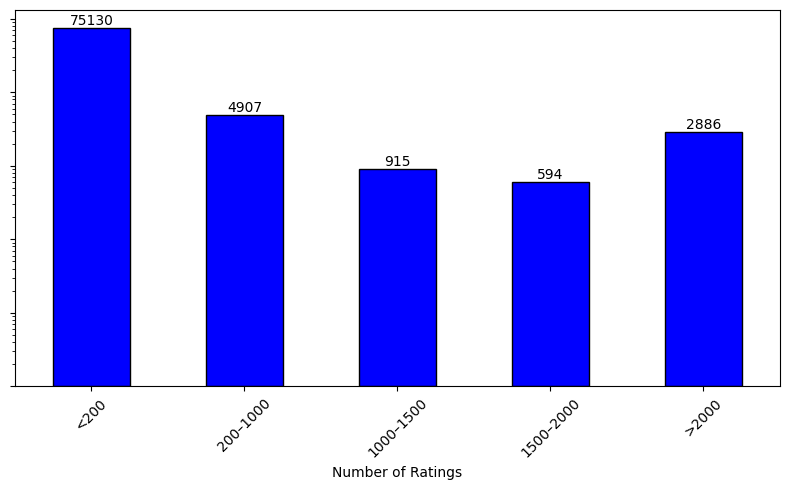

In [12]:
ratings_per_movie = explore_ratings_df.groupby('movieId').size()

TOTAL_RATING_LOWER_BOUND = 200

bins = [0, TOTAL_RATING_LOWER_BOUND, 1000, 1500, 2000, float('inf')]
labels = [f'<{TOTAL_RATING_LOWER_BOUND}', '200–1000', '1000–1500', '1500–2000', '>2000']

binned = pd.cut(ratings_per_movie, bins=bins, labels=labels, right=True)

bin_counts = binned.value_counts().sort_index()

print(f"Movies with at least {TOTAL_RATING_LOWER_BOUND} ratings: ", bin_counts.iloc[1:].sum())

plt.figure(figsize=(8, 5))
ax = bin_counts.plot(kind='bar', color='blue', edgecolor='black', log=True)

for i, value in enumerate(bin_counts):
    ax.text(i, value, str(value), ha='center', va='bottom', fontsize=10)

ax.set_yticklabels([])

plt.xlabel('Number of Ratings')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [13]:

def _parse_year(x):
        x = x.split("(")
        if len(x) <= 1:
            return 0
        try:
            return int(x[-1].split(")")[0])
        except:
            return 0

explore_movies_df.loc[:, "year"] = explore_movies_df["title"].apply(_parse_year)
movies_df_indexed = explore_movies_df.set_index("movieId")

movies_df_indexed.loc[:, "age"] = movies_df_indexed.year.max() - movies_df_indexed.year
        
explore_ratings_df.loc[:, "ratings_per_year"] = explore_ratings_df['movieId'].map(explore_ratings_df['movieId'].value_counts()) / explore_ratings_df['movieId'].map(movies_df_indexed["age"])
filtered_ratings = explore_ratings_df[explore_ratings_df.ratings_per_year > 10]

In [14]:
# Movies with less than 10 ratings per year
less_than_10_ratings = explore_ratings_df[explore_ratings_df['ratings_per_year'] <= 10]
print("All rated ", len(explore_movies_df) - len(unrated_movies))
print("Less or eq than 10 per year ", len(less_than_10_ratings.groupby('movieId').size()))
print("More than 10 per year ", len(filtered_ratings.groupby('movieId').size()))


All rated  84432
Less or eq than 10 per year  72982
More than 10 per year  11450


11450
Movies with at least 10 ratings PER YEAR:  11450


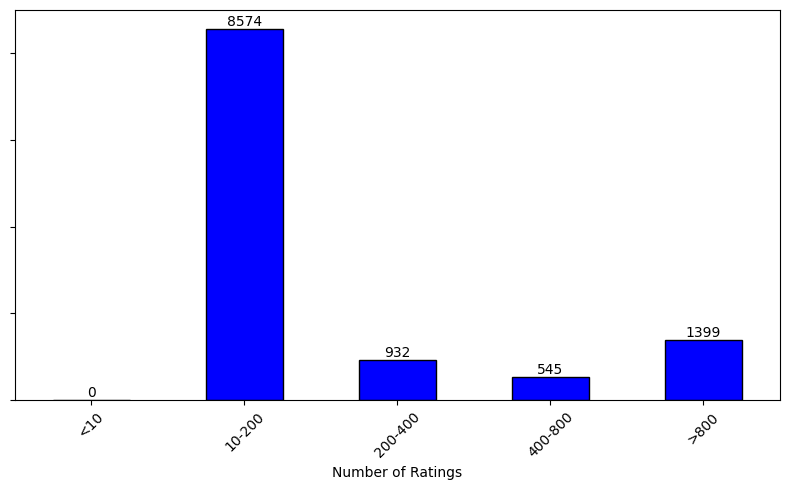

In [15]:
ratings_per_movie = filtered_ratings.groupby('movieId')["ratings_per_year"].max()
print(len(ratings_per_movie))

TOTAL_RATING_LOWER_BOUND = 10

bins = [0, TOTAL_RATING_LOWER_BOUND, 200, 400, 800, float('inf')]
labels = [f'<{TOTAL_RATING_LOWER_BOUND}', '10-200', '200-400', '400-800', '>800']

binned = pd.cut(ratings_per_movie, bins=bins, labels=labels, right=True, include_lowest=True)

bin_counts = binned.value_counts().sort_index()

print(f"Movies with at least {TOTAL_RATING_LOWER_BOUND} ratings PER YEAR: ", bin_counts.sum())

plt.figure(figsize=(8, 5))
ax = bin_counts.plot(kind='bar', color='blue', edgecolor='black')

for i, value in enumerate(bin_counts):
    ax.text(i, value, str(value), ha='center', va='bottom', fontsize=10)

ax.set_yticklabels([])

plt.xlabel('Number of Ratings')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [9]:
filtered_movies["genres"] = filtered_movies["genres"].str.replace("|", ", ", regex=False)
explore_loader.movies_df["genres"] = explore_loader.movies_df["genres"].str.replace("|", ", ", regex=False)
print(filtered_movies.iloc[0])

movieId                                                    1
title                                       Toy Story (1995)
genres       Adventure, Animation, Children, Comedy, Fantasy
plot       A cowboy doll is profoundly threatened and jea...
year                                                    1995
Name: 0, dtype: object


In [23]:
print((filtered_movies[['genres', 'plot']].map(lambda x: x.strip() == '')).sum())

genres    0
plot      0
dtype: int64


In [ ]:
demo_genre_strings = [genres for genres in filtered_movies["genres"]]
print(demo_genre_strings[0])

demo_genres_embeddings = model.encode(demo_genre_strings, show_progress_bar=True)

demo_plot_strings = [plot for plot in filtered_movies["plot"]]
print(demo_plot_strings[0])

demo_plot_embeddings = model.encode(demo_plot_strings, show_progress_bar=True)

np.save('demo_genres_embeddings.npy', demo_genres_embeddings)
np.save('demo_plot_embeddings.npy', demo_plot_embeddings)

print("Demo embeddings saved")

Adventure, Animation, Children, Comedy, Fantasy


Batches:   0%|          | 0/48 [00:00<?, ?it/s]

A cowboy doll is profoundly threatened and jealous when a new spaceman action figure supplants him as top toy in a boy's bedroom.


Batches:   0%|          | 0/48 [00:00<?, ?it/s]

Demo embeddings saved


In [29]:
full_genre_strings = [genres for genres in explore_loader.movies_df["genres"]]
print(full_genre_strings[0])

full_genres_embeddings = model.encode(full_genre_strings, show_progress_bar=True)

full_plot_strings = [plot for plot in explore_loader.movies_df["plot"]]
print(full_plot_strings[0])

full_plot_embeddings = model.encode(full_plot_strings, show_progress_bar=True)

np.save('genres_embeddings.npy', full_genres_embeddings)
np.save('plot_embeddings.npy', full_plot_embeddings)

print("Full embeddings saved")

Adventure, Animation, Children, Comedy, Fantasy


Batches:   0%|          | 0/296 [00:00<?, ?it/s]

A cowboy doll is profoundly threatened and jealous when a new spaceman action figure supplants him as top toy in a boy's bedroom.


Batches:   0%|          | 0/296 [00:00<?, ?it/s]

Full embeddings saved


c:\Users\richa\Desktop\SCHOOL\mgr\diplomka\experiment\EasyStudy\server\venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\richa\Desktop\SCHOOL\mgr\diplomka\experiment\EasyStudy\server\venv\lib\site-packages\umap\umap_.py:1401: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
c:\Users\richa\Desktop\SCHOOL\mgr\diplomka\experiment\EasyStudy\server\venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


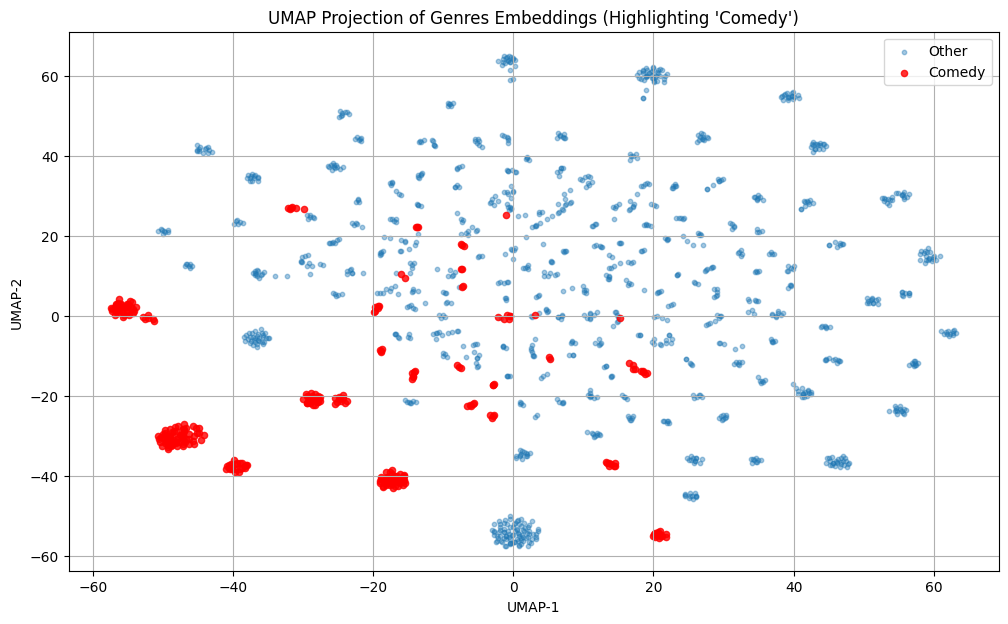

In [10]:
genres_embeddings = np.load('demo_genres_embeddings.npy')

umap_genres = umap.UMAP(
    n_neighbors=3,
    n_components=2,
    random_state=42, 
    metric="cosine",
    min_dist=0.5,
    spread=15)
genres_2d = umap_genres.fit_transform(genres_embeddings)


comedy_mask = filtered_movies['genres'].str.lower().str.split(',').apply(lambda x: len(x) >= 1 and 'comedy' in x)


plt.figure(figsize=(12, 7))
plt.scatter(genres_2d[~comedy_mask, 0], genres_2d[~comedy_mask, 1], s=10, alpha=0.4, label='Other')
plt.scatter(genres_2d[comedy_mask, 0], genres_2d[comedy_mask, 1], s=20, color='red', alpha=0.8, label='Comedy')
plt.title("UMAP Projection of Genres Embeddings (Highlighting 'Comedy')")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend()
plt.grid(True)
plt.show()

c:\Users\richa\Desktop\SCHOOL\mgr\diplomka\experiment\EasyStudy\server\venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\richa\Desktop\SCHOOL\mgr\diplomka\experiment\EasyStudy\server\venv\lib\site-packages\umap\umap_.py:1401: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
c:\Users\richa\Desktop\SCHOOL\mgr\diplomka\experiment\EasyStudy\server\venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


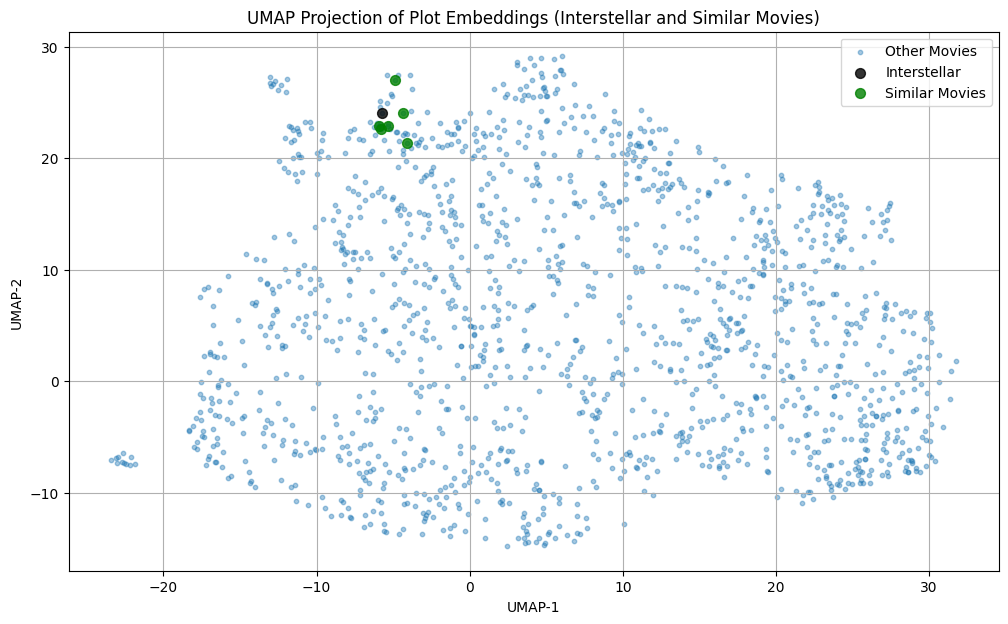

Similar Movies:
The Martian (2015)              An astronaut becomes stranded on Mars after his team assume him dead, and must rely on his ingenuity to find a way to signal to Earth that he is alive and can survive until a potential rescue.
Life (2017)                     A team of scientists aboard the ISS discover a rapidly evolving Martian predator that needs to be kept away from Earth at all costs.
Hitchhiker's Guide to the Gala  Mere seconds before the Earth is to be demolished by an alien construction crew, journeyman Arthur Dent is swept off the planet by his friend Ford Prefect, a researcher penning a new edition of "The Hitchhiker's Guide to the Galaxy."
Ad Astra (2019)                 Astronaut Roy McBride undertakes a mission across an unforgiving solar system to uncover the truth about his missing father and his doomed expedition that now, 30 years later, threatens the universe.
Alien: Covenant (2017)          The crew of a colony ship, bound for a remote planet, discover a

In [11]:
plot_embeddings = np.load('demo_plot_embeddings.npy')

umap_plot = umap.UMAP(
    n_neighbors=20,
    n_components=5,
    random_state=42,
    metric="cosine",
    min_dist=0.5,
    spread=15)
plot_2d = umap_plot.fit_transform(plot_embeddings)

index = filtered_movies[filtered_movies['title'] == "Interstellar (2014)"].index[0]

selected_movie_embedding = plot_embeddings[index]

distances = cosine_distances([selected_movie_embedding], plot_embeddings).flatten()

nearest_indices = np.argsort(distances)[1:7]  # Skip the first one

plt.figure(figsize=(12, 7))

plt.scatter(plot_2d[:, 0], plot_2d[:, 1], s=10, alpha=0.4, label="Other Movies")

plt.scatter(plot_2d[index, 0], plot_2d[index, 1], s=50, color="black", alpha=0.8, label="Interstellar")

plt.scatter(plot_2d[nearest_indices, 0], plot_2d[nearest_indices, 1], s=50, color="green", alpha=0.8, label="Similar Movies")

plt.title("UMAP Projection of Plot Embeddings (Interstellar and Similar Movies)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend()
plt.grid(True)
plt.show()

print("Similar Movies:")
for idx in nearest_indices:
    title = filtered_movies.iloc[idx]['title'][:30]
    plot = filtered_movies.iloc[idx]['plot']
    print(f"{title:<31} {plot}")

## Diversity phase detour

In diversity phase, we want to show pairs of movies that are similar in genres but different in plot, and vice versa.


### Genres 

To find similar movie pairs that share the same genres but have different plots is fairly easy. We have the following seed movies, covering a variety of genres:

- The Godfather - 858
- The Matrix - 2571 
- The Incredibles - 8961
- The Proposal - 69406
- Tyson - 69458

```txt

Movie ID: 858
Most similar by genre: 
Boyz N the Hood (1991)
Crime, Drama
 (Similarity: 1.0000)

Most similar by plot: Godfather: Part III, The (1990)
Follows the lives of three young males living in the Crenshaw ghetto of Los Angeles, dissecting questions of race, relationships, violence, and future prospects.
 (Similarity: 0.5636)

```

TODO: Normalize the similarity scores?

In [29]:
movies = explore_loader.movies_df

genre_movie_ids = [858, 2571, 8961, 69406, 69458]

genre_movies = movies[movies['movieId'].isin(genre_movie_ids)]
genre_movies

,movieId,title,genres,plot,year
443,858,"Godfather, The (1972)","Crime, Drama",The aging patriarch of an organized crime dyna...,1972
1375,2571,"Matrix, The (1999)","Action, Sci-Fi, Thriller",When a beautiful stranger leads computer hacke...,1999
3660,8961,"Incredibles, The (2004)","Action, Adventure, Animation, Children, Comedy","While trying to lead a quiet suburban life, a ...",2004
5168,69406,"Proposal, The (2009)","Comedy, Romance",When New York editor Margaret faces deportatio...,2009
5170,69458,Tyson (2008),Documentary,"A mixture of original interviews, archival foo...",2008


In [ ]:
full_genres_embeddings = np.load('genres_embeddings.npy')
full_plot_embeddings = np.load('plot_embeddings.npy')

def find_most_similar(movie_id, base_embeddings, alt_embeddings, movies_df):
    index = movies_df[movies_df['movieId'] == movie_id].index[0]
    base_embedding = base_embeddings[index]
    alt_embedding = alt_embeddings[index]

    distances = cosine_distances([base_embedding], base_embeddings).flatten()
    nearest_index = np.argsort(distances)[1]  # Skip itself

    similar_movie = movies_df.iloc[nearest_index]
    base_similarity = 1 - distances[nearest_index]

    alt_distance = cosine_distances([alt_embedding], [alt_embeddings[nearest_index]])[0][0]
    alt_similarity = 1 - alt_distance

    return similar_movie, base_similarity, alt_similarity

def print_similarity_info_genres(movie_ids, genre_embeddings, plot_embeddings, movies_df):
    for movie_id in movie_ids:
        genre_match, genre_sim, genre_match_plot_sim = find_most_similar(
            movie_id, genre_embeddings, plot_embeddings, movies_df
        )

        print(f"Movie ID: {movie_id}")

        print(f"Most similar by GENRE:")
        print(f"Title: {genre_match['title']}")
        print(f"Genres: {genre_match['genres']}")
        print(f"Plot: {genre_match['plot']}")
        print(f"Genre similarity: {genre_sim:.4f}")
        print(f"Plot similarity: {genre_match_plot_sim:.4f}\n")

print_similarity_info_genres(genre_movie_ids, full_genres_embeddings, full_plot_embeddings, explore_loader.movies_df)

Movie ID: 858
Most similar by GENRE:
Title: Boyz N the Hood (1991)
Genres: Crime, Drama
Plot: Follows the lives of three young males living in the Crenshaw ghetto of Los Angeles, dissecting questions of race, relationships, violence, and future prospects.
Genre similarity: 1.0000
Plot similarity: 0.2163

Most similar by PLOT:
Title: Godfather: Part III, The (1990)
Genres: Crime, Drama, Mystery, Thriller
Plot: Follows Michael Corleone, now in his 60s, as he seeks to free his family from crime and find a suitable successor to his empire.
Plot similarity: 0.5636
Genre similarity: 0.7630
------------------------------------------------------------------------------------------------------------------------
Movie ID: 2571
Most similar by GENRE:
Title: Island, The (2005)
Genres: Action, Sci-Fi, Thriller
Plot: In 2019, a mercenary pursues a man and woman who escaped a research facility after learning their true fate.
Genre similarity: 1.0000
Plot similarity: 0.3302

Most similar by PLOT:
Titl

### Plot

To find similar movie pairs that share the same plot but have different genres, we will use the following seed movies:

- Ratatouille 50872
- Pocahontas 48
- Naked Gun 3868
- Finding Nemo 6377
- Spies in Disguise 204694
- Home alone 2 2953

In [44]:
plot_movie_ids = [48, 2953, 3868, 6377, 50872, 204694]

plot_movies = movies[movies['movieId'].isin(plot_movie_ids)]
plot_movies

,movieId,title,genres,plot,year
40,48,Pocahontas (1995),"Animation, Children, Drama, Musical, Romance",An English soldier and the daughter of an Algo...,1995
1575,2953,Home Alone 2: Lost in New York (1992),"Children, Comedy",One year after Kevin McCallister was left home...,1992
2017,3868,"Naked Gun: From the Files of Police Squad!, Th...","Action, Comedy, Crime, Romance",Incompetent police Detective Frank Drebin must...,1988
2974,6377,Finding Nemo (2003),"Adventure, Animation, Children, Comedy",After his son is captured in the Great Barrier...,2003
4533,50872,Ratatouille (2007),"Animation, Children, Drama",A rat who can cook makes an unusual alliance w...,2007
8701,204694,Spies in Disguise (2019),"Action, Adventure, Animation",When the world's best spy is turned into a pig...,2019


In [46]:
def print_similarity_info_plot(movie_ids, genre_embeddings, plot_embeddings, movies_df):
    for movie_id in movie_ids:
        plot_match, plot_sim, plot_match_genre_sim = find_most_similar(
            movie_id, plot_embeddings, genre_embeddings, movies_df
        )

        print(f"Movie ID: {movie_id}")

        print(f"Most similar by PLOT:")
        print(f"Title: {plot_match['title']}")
        print(f"Genres: {plot_match['genres']}")
        print(f"Plot: {plot_match['plot']}")
        print(f"Plot similarity: {plot_sim:.4f}")
        print(f"Genre similarity: {plot_match_genre_sim:.4f}")
        print("-" * 120)

print_similarity_info_plot(plot_movie_ids, full_genres_embeddings, full_plot_embeddings, explore_loader.movies_df)

Movie ID: 48
Most similar by PLOT:
Title: New World, The (2005)
Genres: Adventure, Drama, Romance
Plot: The story of the English exploration of Virginia, and of the changing world and loves of Pocahontas.
Plot similarity: 0.5987
Genre similarity: 0.7693
------------------------------------------------------------------------------------------------------------------------
Movie ID: 2953
Most similar by PLOT:
Title: Rover, The (2014)
Genres: Crime, Drama
Plot: 10 years after a global economic collapse, a hardened loner pursues the men who stole his only possession, his car. Along the way, he captures one of the thieves' brother, and the duo form an uneasy bond during the dangerous journey.
Plot similarity: 0.5141
Genre similarity: 0.5251
------------------------------------------------------------------------------------------------------------------------
Movie ID: 3868
Most similar by PLOT:
Title: Mission: Impossible (1996)
Genres: Action, Adventure, Mystery, Thriller
Plot: An America

c:\Users\richa\Desktop\SCHOOL\mgr\diplomka\experiment\EasyStudy\server\venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\richa\Desktop\SCHOOL\mgr\diplomka\experiment\EasyStudy\server\venv\lib\site-packages\umap\umap_.py:1401: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
c:\Users\richa\Desktop\SCHOOL\mgr\diplomka\experiment\EasyStudy\server\venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


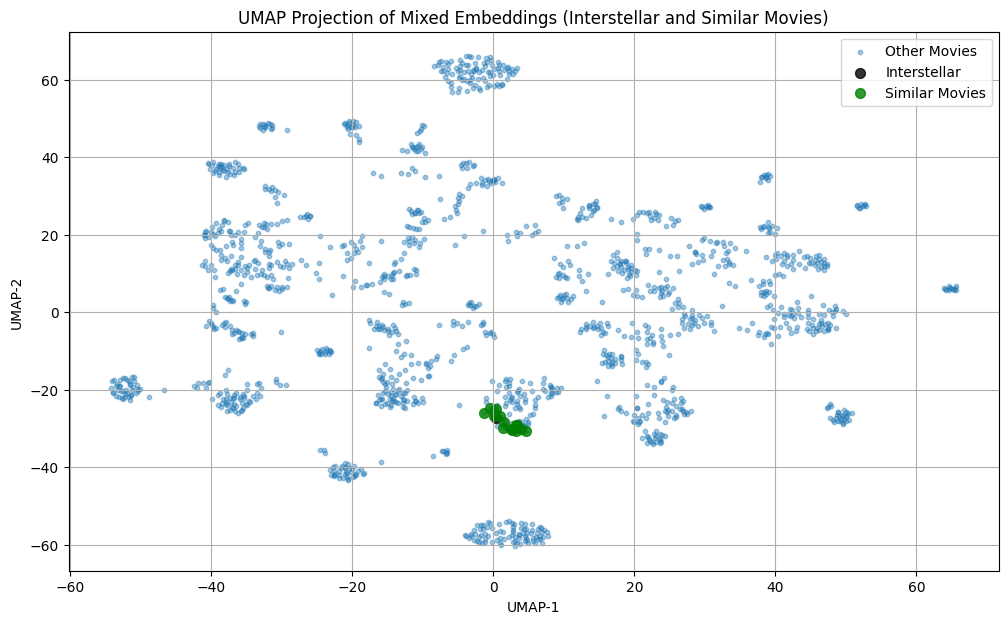


Similar Movies (Genre=1.4, Plot=0.8):
Edge of Tomorrow (20   Action|Sci-Fi|IMAX               A man fighting in a war against aliens must relive the same day every time he di
Gravity (2013)         Action|Sci-Fi|IMAX               Dr Ryan Stone, an engineer on her first space mission, and Matt Kowalski, an ast
John Carter (2012)     Action|Adventure|Sci-Fi|IMAX     A war-weary former army captain is inexplicably transported to Mars and reluctan
Transcendence (2014)   Drama|Sci-Fi|IMAX                A scientist's drive for artificial intelligence takes on dangerous implications 
Elysium (2013)         Action|Drama|Sci-Fi|IMAX         In the year 2154, the very wealthy live on a man-made space station while the re
Star Trek (2009)       Action|Adventure|Sci-Fi|IMAX     The brash James T. Kirk tries to live up to his father's legacy with Mr. Spock k
Pacific Rim (2013)     Action|Adventure|Sci-Fi|IMAX     As a war between humankind and monstrous sea creatures wages on, a former pilot 
Mo

In [50]:

umap_genres = umap.UMAP(
    n_neighbors=20,
    n_components=2,
    random_state=42, 
    metric="cosine",
    min_dist=0.3,
    spread=15)

GENRE_WEIGHT = 1.4
PLOT_WEIGHT = 0.8

final_embeddings = (GENRE_WEIGHT * genres_embeddings + PLOT_WEIGHT * plot_embeddings) 

coords_2d = umap_genres.fit_transform(final_embeddings)

index = filtered_movies[filtered_movies['title'] == "Interstellar (2014)"].index[0]

selected_movie_embedding = final_embeddings[index]

distances = cosine_distances([selected_movie_embedding], final_embeddings).flatten()

nearest_indices = np.argsort(distances)[1:16]  # Skip the first one

plt.figure(figsize=(12, 7))

plt.scatter(coords_2d[:, 0], coords_2d[:, 1], s=10, alpha=0.4, label="Other Movies")

plt.scatter(coords_2d[index, 0], coords_2d[index, 1], s=50, color="black", alpha=0.8, label="Interstellar")

plt.scatter(coords_2d[nearest_indices, 0], coords_2d[nearest_indices, 1], s=50, color="green", alpha=0.8, label="Similar Movies")

plt.title("UMAP Projection of Mixed Embeddings (Interstellar and Similar Movies)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend()
plt.grid(True)
plt.show()

print(f"\nSimilar Movies (Genre={GENRE_WEIGHT}, Plot={PLOT_WEIGHT}):")
for idx in nearest_indices:
    movie = filtered_movies.iloc[idx]
    title = movie["title"][:20]
    genres = movie["genres"][:30]
    plot = movie["plot"][:80]

    print(f"{title:<22} {genres:<32} {plot}")

c:\Users\richa\Desktop\SCHOOL\mgr\diplomka\experiment\EasyStudy\server\venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\richa\Desktop\SCHOOL\mgr\diplomka\experiment\EasyStudy\server\venv\lib\site-packages\umap\umap_.py:1401: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
c:\Users\richa\Desktop\SCHOOL\mgr\diplomka\experiment\EasyStudy\server\venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


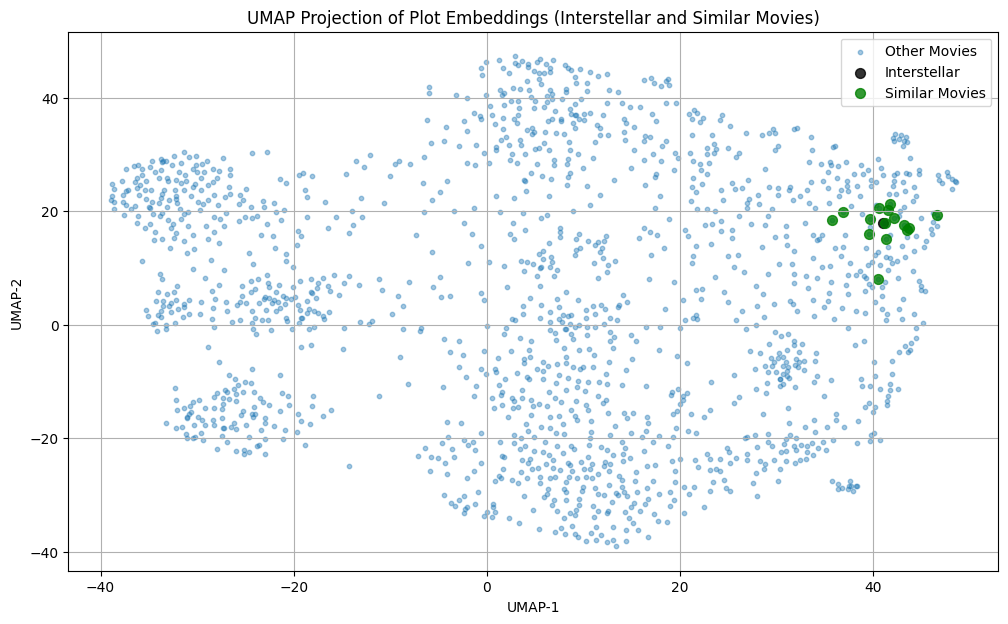


Similar Movies (Genre=0.8, Plot=1.4):
The Martian (2015)     Adventure|Drama|Sci-Fi           An astronaut becomes stranded on Mars after his team assume him dead, and must r
Hitchhiker's Guide t   Adventure|Comedy|Sci-Fi          Mere seconds before the Earth is to be demolished by an alien construction crew,
John Carter (2012)     Action|Adventure|Sci-Fi|IMAX     A war-weary former army captain is inexplicably transported to Mars and reluctan
Planet of the Apes (   Action|Adventure|Drama|Sci-Fi    In 2029, an Air Force astronaut crash-lands on a mysterious planet where evolved
Spaceballs (1987)      Comedy|Sci-Fi                    A star-pilot for hire and his trusty sidekick must come to the rescue of a princ
Elysium (2013)         Action|Drama|Sci-Fi|IMAX         In the year 2154, the very wealthy live on a man-made space station while the re
Man of Steel (2013)    Action|Adventure|Fantasy|Sci-F   An alien child is evacuated from his dying world and sent to Earth to live among
Ed

In [51]:

umap_genres = umap.UMAP(
    n_neighbors=20,
    n_components=2,
    random_state=42, 
    metric="cosine",
    min_dist=0.3,
    spread=15)

GENRE_WEIGHT = 0.8
PLOT_WEIGHT = 1.4

final_embeddings = (GENRE_WEIGHT * genres_embeddings + PLOT_WEIGHT * plot_embeddings) 

coords_2d = umap_genres.fit_transform(final_embeddings)

index = filtered_movies[filtered_movies['title'] == "Interstellar (2014)"].index[0]

selected_movie_embedding = final_embeddings[index]

distances = cosine_distances([selected_movie_embedding], final_embeddings).flatten()

nearest_indices = np.argsort(distances)[1:16]  # Skip the first one

plt.figure(figsize=(12, 7))

plt.scatter(coords_2d[:, 0], coords_2d[:, 1], s=10, alpha=0.4, label="Other Movies")

plt.scatter(coords_2d[index, 0], coords_2d[index, 1], s=50, color="black", alpha=0.8, label="Interstellar")

plt.scatter(coords_2d[nearest_indices, 0], coords_2d[nearest_indices, 1], s=50, color="green", alpha=0.8, label="Similar Movies")

plt.title("UMAP Projection of Plot Embeddings (Interstellar and Similar Movies)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend()
plt.grid(True)
plt.show()

print(f"\nSimilar Movies (Genre={GENRE_WEIGHT}, Plot={PLOT_WEIGHT}):")
for idx in nearest_indices:
    movie = filtered_movies.iloc[idx]
    title = movie["title"][:20]
    genres = movie["genres"][:30]
    plot = movie["plot"][:80]

    print(f"{title:<22} {genres:<32} {plot}")

c:\Users\richa\Desktop\SCHOOL\mgr\diplomka\experiment\EasyStudy\server\venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\richa\Desktop\SCHOOL\mgr\diplomka\experiment\EasyStudy\server\venv\lib\site-packages\umap\umap_.py:1401: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


[ 118  779  877  299  267  747 1085  367  435 1462  937  969  946   99
 1170]


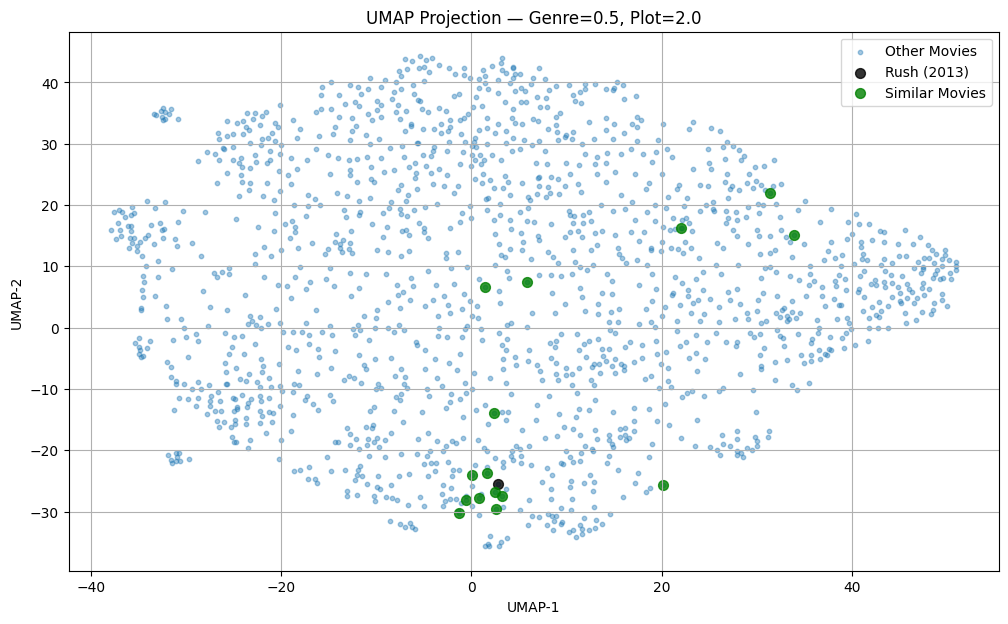

Sing (2016)            Animation|Children|Comedy        In a city of humanoid animals, a hustling theater impresario

Similar Movies (Genre=0.5, Plot=2.0):
0.4334 Dumbo (1941)                     Animation|Children|Drama|Musical      Ridiculed because of his enormous ears, a young circus eleph
0.4778 Happy Feet (2006)                Adventure|Animation|Children|Comedy   Into the world of the Emperor Penguins, who find their soul 
0.4957 Synecdoche, New York (2008)      Comedy|Drama                          A theater director struggles with his work and the women in 
0.5248 Antz (1998)                      Adventure|Animation|Children|Comedy   A rather neurotic ant tries to break from his totalitarian s
0.5279 Metropolis (1927)                Drama|Sci-Fi                          In a futuristic city sharply divided between the working cla
0.5284 Over the Hedge (2006)            Adventure|Animation|Children|Comedy   A scheming raccoon fools a mismatched family of forest creat
0.5311 Mad

c:\Users\richa\Desktop\SCHOOL\mgr\diplomka\experiment\EasyStudy\server\venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\richa\Desktop\SCHOOL\mgr\diplomka\experiment\EasyStudy\server\venv\lib\site-packages\umap\umap_.py:1401: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


[ 118 1101  279  747  750  367 1120  307  664  270  336 1296  779 1262
  299]


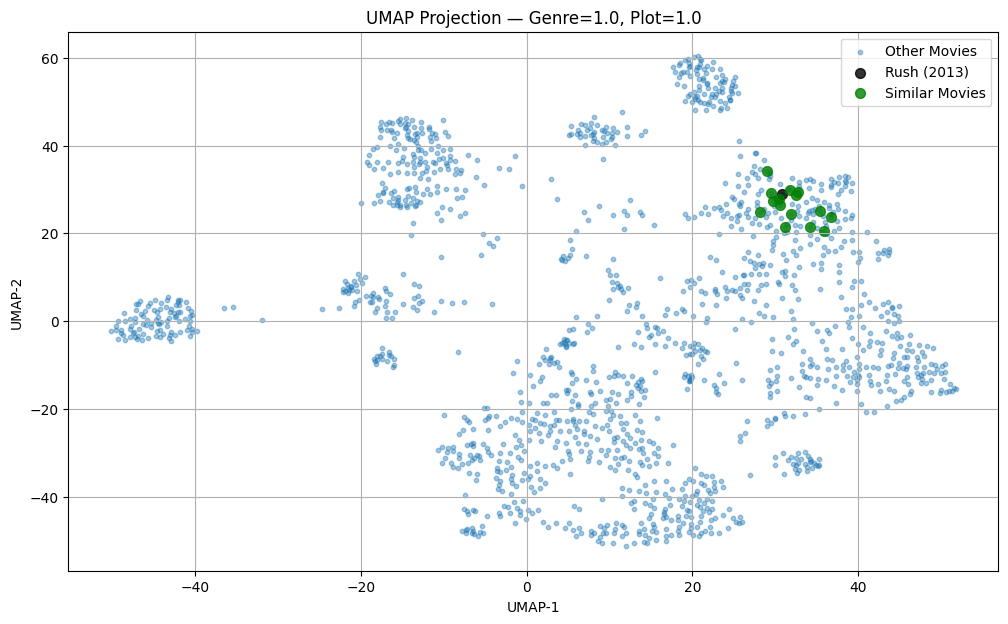

Sing (2016)            Animation|Children|Comedy        In a city of humanoid animals, a hustling theater impresario

Similar Movies (Genre=1.0, Plot=1.0):
0.2280 Dumbo (1941)                     Animation|Children|Drama|Musical      Ridiculed because of his enormous ears, a young circus eleph
0.2784 Hotel Transylvania (2012)        Animation|Children|Comedy             Dracula, who operates a high-end resort away from the human 
0.2831 Jungle Book, The (1967)          Animation|Children|Comedy|Musical     Bagheera the Panther and Baloo the Bear have a difficult tim
0.2842 Over the Hedge (2006)            Adventure|Animation|Children|Comedy   A scheming raccoon fools a mismatched family of forest creat
0.2922 Cars (2006)                      Animation|Children|Comedy             On the way to the biggest race of his life, a hotshot rookie
0.2974 Robin Hood (1973)                Adventure|Animation|Children|Comedy   The story of the legendary British outlaw portrayed with the
0.2990 Cro

c:\Users\richa\Desktop\SCHOOL\mgr\diplomka\experiment\EasyStudy\server\venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\richa\Desktop\SCHOOL\mgr\diplomka\experiment\EasyStudy\server\venv\lib\site-packages\umap\umap_.py:1401: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


[1101  750  664 1354  423  279  747  307  852 1481 1454  518 1267  580
 1018]


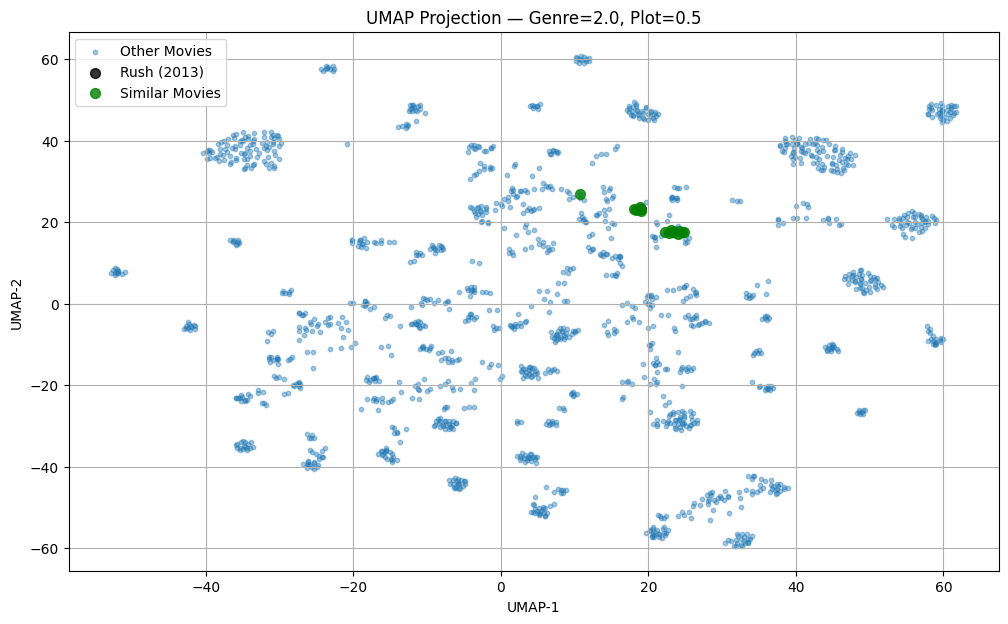

Sing (2016)            Animation|Children|Comedy        In a city of humanoid animals, a hustling theater impresario

Similar Movies (Genre=2.0, Plot=0.5):
0.0367 Hotel Transylvania (2012)        Animation|Children|Comedy             Dracula, who operates a high-end resort away from the human 
0.0378 Cars (2006)                      Animation|Children|Comedy             On the way to the biggest race of his life, a hotshot rookie
0.0388 Shark Tale (2004)                Animation|Children|Comedy             When a son of a gangster shark boss is accidentally killed w
0.0417 The Boss Baby (2017)             Animation|Children|Comedy             A suit-wearing, briefcase-carrying baby pairs up with his 7-
0.0418 Chicken Run (2000)               Animation|Children|Comedy             When a cockerel apparently flies into a chicken farm, the ch
0.0931 Jungle Book, The (1967)          Animation|Children|Comedy|Musical     Bagheera the Panther and Baloo the Bear have a difficult tim
0.1034 Ove

In [67]:
weight_combinations = [
    (0.5, 2.0),
    (1.0, 1.0),
    (2.0, 0.5)
]

for genre_weight, plot_weight in weight_combinations:
    final_embeddings = genre_weight * genres_embeddings + plot_weight * plot_embeddings
    coords_2d = umap_genres.fit_transform(final_embeddings)

    index = filtered_movies[filtered_movies['title'] == "Sing (2016)"].index[0]
    selected_movie_embedding = final_embeddings[index]

    distances = cosine_distances([selected_movie_embedding], final_embeddings).flatten()
    nearest_indices = np.argsort(distances)[1:16]
    print(nearest_indices)
    # Plot
    plt.figure(figsize=(12, 7))
    plt.scatter(coords_2d[:, 0], coords_2d[:, 1], s=10, alpha=0.4, label="Other Movies")
    plt.scatter(coords_2d[index, 0], coords_2d[index, 1], s=50, color="black", alpha=0.8, label="Rush (2013)")
    plt.scatter(coords_2d[nearest_indices, 0], coords_2d[nearest_indices, 1], s=50, color="green", alpha=0.8, label="Similar Movies")

    plt.title(f"UMAP Projection — Genre={genre_weight}, Plot={plot_weight}")
    plt.xlabel("UMAP-1")
    plt.ylabel("UMAP-2")
    plt.legend()
    plt.grid(True)
    plt.show()

    selected_movie = filtered_movies.iloc[index]
    title = selected_movie["title"][:30]
    genres = selected_movie["genres"][:35]
    plot = selected_movie["plot"][:60]
    print(f"{title:<22} {genres:<32} {plot}")

    print(f"\nSimilar Movies (Genre={genre_weight}, Plot={plot_weight}):")
    for i, idx in enumerate(nearest_indices):
        movie = filtered_movies.iloc[idx]
        title = movie["title"][:30]
        genres = movie["genres"][:35]
        plot = movie["plot"][:60]

        print(f"{distances[idx]:.4f} {title:<32} {genres:<37} {plot}")
